# Robotic Arm - Panda Gym 

In [1]:
import numpy as np
import gymnasium as gym
import panda_gym
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch

from ddpg_algo import DDPGTrainer

* Robot: Simulates the Franka Emika Panda robotic arm for manipulation tasks.
<br>

* Observation Space:
    - All tasks include gripper position and velocity (6 values).
    - Tasks involving objects include their position, orientation, and velocities (linear and rotational, 12 values per object).
    - Gripper opening (distance between fingers) is included if not constrained closed (1 value).

* Action Space:
    - Gripper movement commands (3 values for x, y, and z axes).
    - Gripper opening/closing command (1 value).
    
* Simulation Details:
    - Simulation runs 20 timesteps per agent action (2ms each).
    - Overall interaction frequency is 25Hz.
    - Most tasks have episodes lasting 2 seconds (50 interactions).
    
* Reward Function:
    - Default reward is sparse: 0 for successful completion (within 5cm tolerance), -1 otherwise.
    - Sparse rewards are simpler to define but lack information on progress.

# PandaReach-v3

* Task: A target position must be reached with the gripper. This target position is randomly generated in a volume of 30 cm × 30 cm × 30 cm

In [2]:
env = gym.make(
    "PandaReach-v3",
    render_mode="rgb_array",
    renderer="OpenGL",
    render_target_position=[0, 0.15, 0.25],
    render_distance=0.85,
    render_yaw=135,
    render_pitch=-20,
)

pybullet build time: Nov 28 2023 23:45:17



Observation Space: Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (6,), float32))

Action Space:  Box(-1.0, 1.0, (3,), float32)

Initial State:  ({'observation': array([ 3.8439669e-02, -2.1944723e-12,  1.9740014e-01,  0.0000000e+00,
       -0.0000000e+00,  0.0000000e+00], dtype=float32), 'achieved_goal': array([ 3.8439669e-02, -2.1944723e-12,  1.9740014e-01], dtype=float32), 'desired_goal': array([0.01287401, 0.03240791, 0.16597077], dtype=float32)}, {'is_success': array(False)})

A step in the environment:  ({'observation': array([0.05612974, 0.02471757, 0.20918499, 0.54309   , 1.1585152 ,
       0.51952785], dtype=float32), 'achieved_goal': array([0.05612974, 0.02471757, 0.20918499], dtype=float32), 'desired_goal': array([0.01287401, 0.03240791, 0.16597077], dtype=float32)}, -1.0, False, False, {'is_success': False})


Rendered Environment: 


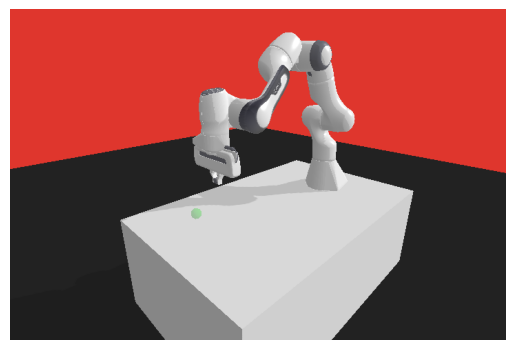

In [3]:
print('\nObservation Space:', env.observation_space)
print('\nAction Space: ', env.action_space)
print('\nInitial State: ',env.reset())
print('\nA step in the environment: ', env.step(np.array(1.0)))
print('\n\nRendered Environment: ')
env.reset()
plt.axis('off')
plt.imshow(env.render())
plt.show()

In [4]:
obs_shape = env.observation_space['observation'].shape[0] + \
            env.observation_space['achieved_goal'].shape[0] + \
            env.observation_space['desired_goal'].shape[0]

# Training - Obtain Expert Policy

1. **Initialization**:
   - Set hyperparameters, and initialize actor annd critic networks.
   - Initialize replay buffer memory.

2. **Training Loop**:
   - Loop through a specified number of episodes:
     - Reset the environment to get the initial observation.
     - While the episode is not done:
       - Select an action using the actor network with exploration noise.
       - Execute the action in the environment and observe the next state and reward.
       - Store the experience (state, action, reward, next_state, done) in the replay buffer.
       - Perform HER augmentation on the replay buffer.
       - Sample a batch of experiences from the replay buffer.
       - Optimize the critic network:
         - Compute target Q-values using the target critic networks.
         - Compute critic loss and perform gradient descent.
       - Update the actor network:
         - Compute actor loss and perform gradient descent.
       - Update the target critic network using a soft update rule.

3. **HER Augmentation**:
   - For each sample in the replay buffer, apply Hindsight Experience Replay by randomly sampling future states and goals.
   - Store the augmented experiences in the replay buffer.

4. **Optimize Model**:
   - If enough experiences are available in the replay buffer:
     - Sample a batch of experiences.
     - Compute target Q-values for both critic networks.
     - Compute critic loss and perform gradient descent.
     - Compute actor loss and perform gradient descent.
     - Update the target actor network.
     - Update the target critic network.

In [7]:
expert = DDPGTrainer(env=env, input_dims=obs_shape, agent_name='Expert', model_save_path='./Models/Expert/', 
                    exploration_period=200)

Training..:  20%|█████▉                       | 102/500 [00:11<00:41,  9.55it/s]

Episode: 100 	 Steps: 50 	 Score: -50.0 	 Average score: -34.0


Training..:  41%|███████████▊                 | 204/500 [00:18<00:17, 16.45it/s]

Episode: 200 	 Steps: 2 	 Score: -1.0 	 Average score: -5.9


Training..:  61%|█████████████████▌           | 303/500 [00:25<00:11, 16.73it/s]

Episode: 300 	 Steps: 2 	 Score: -1.0 	 Average score: -2.1


Training..:  80%|███████████████████████▎     | 402/500 [00:31<00:05, 16.57it/s]

Episode: 400 	 Steps: 2 	 Score: -1.0 	 Average score: -2.0


Training..: 100%|█████████████████████████████| 500/500 [00:37<00:00, 13.33it/s]


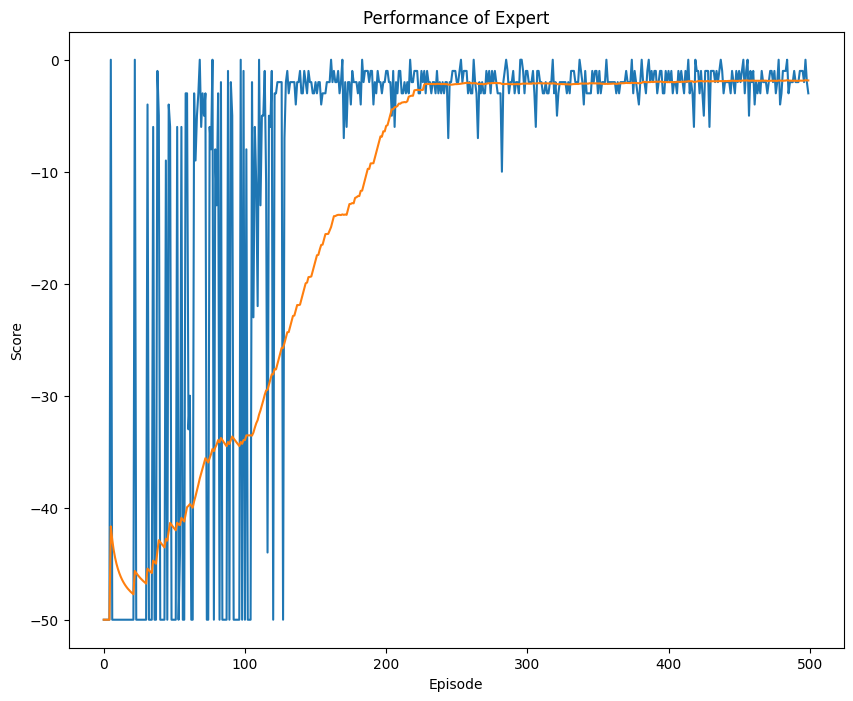

In [8]:
score_history, avg_score_history = expert.ddpg_train(n_episodes=500, opt_steps=10, print_every=100,
                                                    plot_save_path='../Results/DDPG/Expert Performance.png')

In [9]:
expert.save_model()

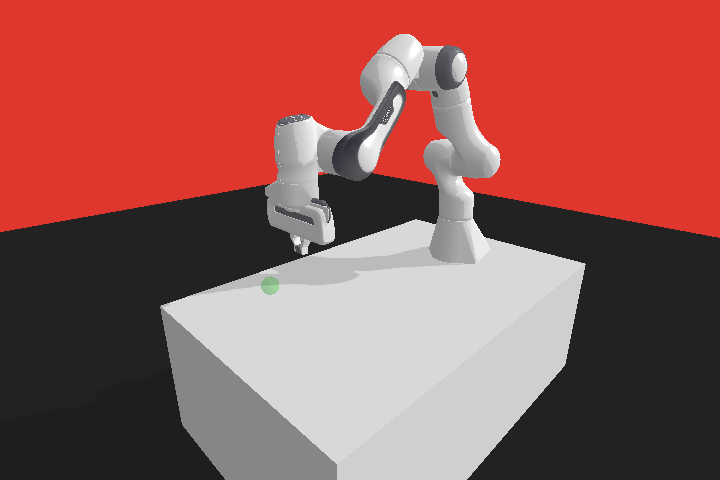

Expert Reward:  -2.0


In [10]:
expert_reward = expert.test_model(env=env, steps=100, render_save_path='../Results/DDPG/Expert Policy', fps=5)
print('Expert Reward: ', expert_reward)

# IRL Algorithm

* To train new agents, instead of utilizing the (predefined) returned reward from the training environment, it incorporates the reward function of the expert derived from the IRL algorithm. This reward function involves a weight term (w) and observation space (Φ(s)) obtained through the IRL algorithm.

* Feature Expectations (µ(π)): The expected discounted accumulated feature vector for a policy π (captures the long-term effects of a policy on state features).

* We can estimate the expert's feature expectations (µE) from observed monte carlo trajectories.

* The empirical estimate for µE = µ(πE) based on a set of m observed expert trajectories is given by:

$$µ̂_E = \frac{1}{m} ∑_m ∑_t (γ^t * φ(ŝ(i)_t))$$

In [5]:
expert = DDPGTrainer(env=env, input_dims=obs_shape, agent_name='Expert', model_load_path='./Models/Expert/')

In [6]:
def compute_average_feature(agent, m=2000):
        """
        Calculate average feature vector (feature expectation) and average reward over m episodes.
        """
        with torch.inference_mode():
            feature_sum, reward_sum = None, None

            for i in tqdm(range(m), desc='Calculating Average Feature Vector and Reward'):
                reward, states = agent.test_model(steps=1000, save_states=True)

                # mean feature vector across the episode
                episode_mean = torch.stack(states).mean(0)

                if feature_sum is None:
                    feature_sum, reward_sum = episode_mean, reward
                else:
                    feature_sum += episode_mean
                    reward_sum += reward

            # µ̂E = (1/m) ∑_m ∑_t (γ^t φ(ŝ(i)_t))  where γ ≈ 1
            feature_sum /= m
            reward_sum /= m

            print('\nFeature Expectation: ',feature_sum)
            print('\nAverage Reward: ',reward_sum)

        return feature_sum, reward_sum

In [8]:
expert_feature_expectation, expert_mean_reward = compute_average_feature(expert, m=1000)   # µ_E

Calculating Average Feature Vector and Reward: 100%|█| 1000/1000 [00:31<00:00, 3



Feature Expectation:  tensor([[ 1.9802e-02,  1.6197e-04,  1.7195e-01, -2.6903e-01, -2.0087e-02,
         -2.9450e-01,  1.9802e-02,  1.6197e-04,  1.7195e-01, -4.3564e-04,
          6.9595e-04,  1.4468e-01]], device='cuda:0')

Average Reward:  -1.768


## IRL algorithm using Projection method

1. **Initialization:**
   - Randomly pick an initial policy, denoted as π(0).
   - Compute the feature expectation, µ(0), using Monte Carlo or other approximation methods.
   - Set iteration counter i = 1.

2. **Margin Computation:**
   - Compute the margin, t(i), as the maximum margin between the current feature expectation and those of previous policies.
   - Compute margin using projection method to find the optimal weight vector w(i).

3. **Termination Check:**
   - If the margin t(i) is less than or equal to a predefined threshold ε, terminate the algorithm.

4. **IRL Training:**
   - Use a Reinforcement Learning (RL) algorithm to compute the optimal policy π(i) for the Markov Decision Process (MDP) with rewards defined by the weight vector w(i).

5. **Update Feature Expectation:**
   - Compute or estimate the feature expectation, µ(i), based on the new policy π(i).

6. **Iteration Update:**
   - Increment the iteration counter i.

7. **Repeat:**
   - Return to step 2 and iterate through the process until the termination condition is met.

Upon termination, the algorithm returns a set of policies {π(i) : i = 0 . . . n}, representing a sequence of policies that approximate the expert's behavior.

In [8]:
def projection_method_algorithm(env, epsilon=0.001, m=2000, n_episodes=100,
                                opt_steps=10, exploration_period=100, save_render=True, fps=5):
    
    feature_expectation = []
    feature_expectation_bar = []
    weights = []
    margins = []
    rewards = []
    obs_shape = env.observation_space['observation'].shape[0] + \
            env.observation_space['achieved_goal'].shape[0] + \
            env.observation_space['desired_goal'].shape[0]
    train_another = ''

    for i in range(100):
        print(f"\n-------------------------------------- Iteration: {i} --------------------------------------\n")
        apprentice = DDPGTrainer(env=env, input_dims=obs_shape, agent_name=f'Apprentice {i}', 
                                model_save_path=f'./Models/Apprentice {i}/', 
                                exploration_period=exploration_period)

        # Step 1: Initialization
        if i == 0:
            observation, info = env.reset()
            current_observation, current_achieved_goal, current_desired_goal = observation.values()
            state = np.concatenate((current_observation, current_achieved_goal, current_desired_goal))
            sample_feature = torch.tensor(state, dtype=torch.float32)
            
            w_0 = torch.randn(sample_feature.size(0), 1).div_(torch.randn(1).norm())
            weights.append(w_0)
            apprentice.ddpg_train(n_episodes=n_episodes, opt_steps=opt_steps, 
                                 reward_weights=w_0, print_every=n_episodes+1, 
                                 plot_save_path=f'../Results/DDPG/Apprentice_{i} Performance.png')
            apprentice_feature_expectation, apprentice_reward = compute_average_feature(agent=apprentice, m=m)
            
            rewards.append(apprentice_reward)
            margins.append(1)
            feature_expectation.append(apprentice_feature_expectation)
            
            print("Expert Feature Expectation:", expert_feature_expectation)
            
        else:
            # Step 2: IRL
            # First iteration of step 2 of algorithm
            if i == 1:
                feature_expectation_bar.append(feature_expectation[i - 1])       # µ¯^(0) = µ^(0)
                weights.append((expert_feature_expectation - feature_expectation[i - 1]).view(-1, 1))   # w^(1) = µ_E - µ^(0)
                margins.append((expert_feature_expectation - feature_expectation_bar[i - 1]).norm().item())
                print("Weight:", weights[i])
                print("Margin:", margins[i])

            # Iterations 2 and onward of step 2 of algorithm
            else:
                A = feature_expectation_bar[i - 2]              # µ¯(i−2)
                B = feature_expectation[i - 1] - A              # (µ(i−1) − µ¯(i−2))
                C = expert_feature_expectation - A              # µ_E − µ¯(i−2)

                feature_expectation_bar.append(A + ((B.view(-1, 1).t() @ C.view(-1, 1)) / \
                                                    (B.view(-1, 1).t() @ B.view(-1, 1))) * B)  # projection method step

                # w(i) = µ_E − μ¯(i−1)
                weight = (expert_feature_expectation - feature_expectation_bar[i - 1]).view(-1, 1)

                # t(i) = ∥µ_E − µ¯(i−1)∥_2
                margin = (expert_feature_expectation - feature_expectation_bar[i - 1]).norm().item()
                
                weights.append(weight)
                margins.append(margin)
                
                print("Margin:", margins[i])
                print("Weight:", weights[i])
                
                train_another = input('Train another apprentice agent? (y/n): ').lower()

            # Step 3: Termination condition
            if margins[i] <= epsilon or train_another=='n':   # terminate with margin ≤ ∈ (or no. of iterations)
                break

            # Step 4: IRL training
            apprentice.ddpg_train(n_episodes=n_episodes, opt_steps=opt_steps, 
                                 reward_weights=weights[-1], print_every=n_episodes+1, 
                                 plot_save_path=f'../Results/DDPG/Apprentice_{i} Performance.png')
            apprentice.save_model()
            
            if save_render:
                apprentice_reward = apprentice.test_model(steps=1000, render_save_path=f'../Results/DDPG/Apprentice {i} Policy', fps=fps)
                print(f'{apprentice.agent_name} Reward: ', apprentice_reward)

            # Step 5: Update feature expectation
            apprentice_feature_expectation, apprentice_reward = compute_average_feature(agent=apprentice, m=m)
            rewards.append(apprentice_reward)
            feature_expectation.append(apprentice_feature_expectation)

        print("")
        
    return rewards, margins


-------------------------------------- Iteration: 0 --------------------------------------



Training..: 100%|█████████████████████████████| 400/400 [04:14<00:00,  1.57it/s]


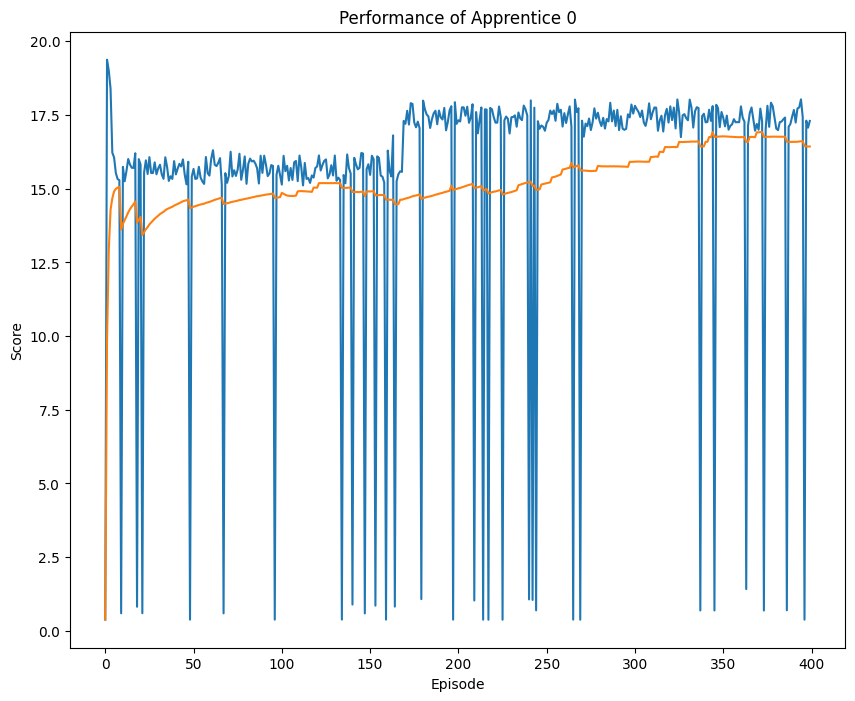

Calculating Average Feature Vector and Reward: 100%|█| 500/500 [00:45<00:00, 10.



Feature Expectation:  tensor([[-0.6753, -0.5237,  0.0256, -0.4165, -0.2237, -0.0975, -0.6753, -0.5237,
          0.0256,  0.0011,  0.0055,  0.1541]], device='cuda:0')

Average Reward:  -47.256
Expert Feature Expectation: tensor([[ 1.9802e-02,  1.6197e-04,  1.7195e-01, -2.6903e-01, -2.0087e-02,
         -2.9450e-01,  1.9802e-02,  1.6197e-04,  1.7195e-01, -4.3564e-04,
          6.9595e-04,  1.4468e-01]], device='cuda:0')


-------------------------------------- Iteration: 1 --------------------------------------

Weight: tensor([[ 0.6951],
        [ 0.5238],
        [ 0.1464],
        [ 0.1474],
        [ 0.2036],
        [-0.1970],
        [ 0.6951],
        [ 0.5238],
        [ 0.1464],
        [-0.0016],
        [-0.0048],
        [-0.0094]], device='cuda:0')
Margin: 1.288398027420044


Training..: 100%|█████████████████████████████| 400/400 [01:06<00:00,  5.99it/s]


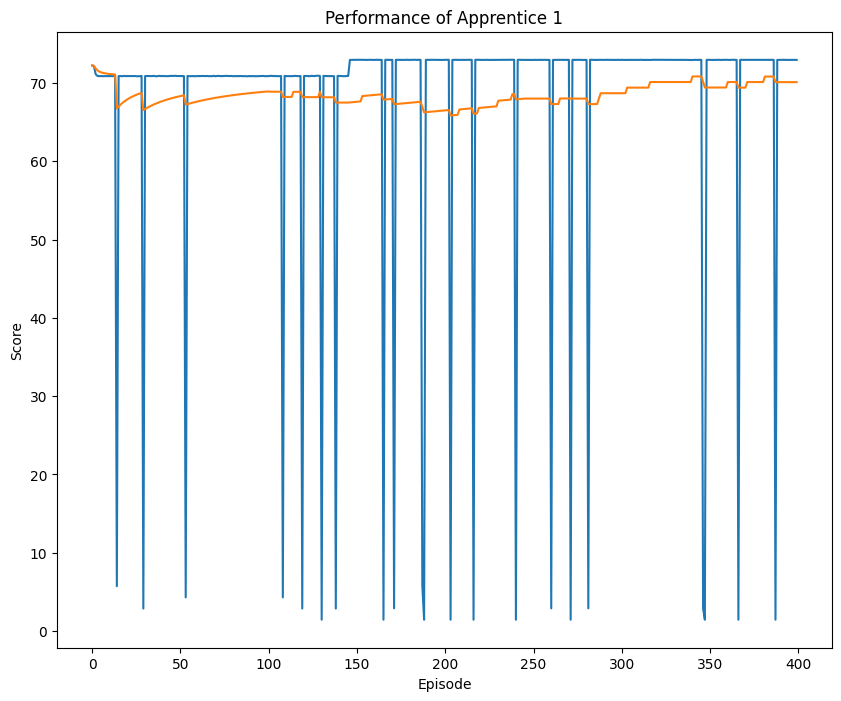

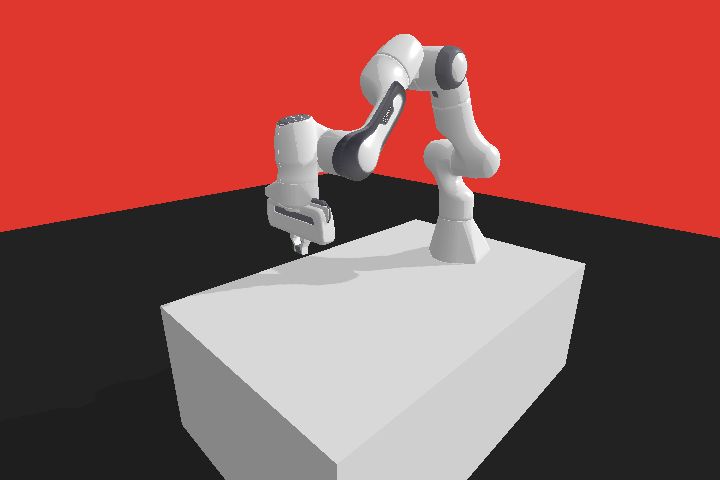

Apprentice 1 Reward:  -50.0


Calculating Average Feature Vector and Reward: 100%|█| 500/500 [00:40<00:00, 12.



Feature Expectation:  tensor([[-0.0182,  0.3565,  0.4574, -0.0181,  0.1523,  0.1202, -0.0182,  0.3565,
          0.4574,  0.0042,  0.0031,  0.1535]], device='cuda:0')

Average Reward:  -48.14


-------------------------------------- Iteration: 2 --------------------------------------

Margin: 0.5595253705978394
Weight: tensor([[ 0.2642],
        [-0.0532],
        [-0.1368],
        [-0.1137],
        [-0.0429],
        [-0.3398],
        [ 0.2642],
        [-0.0532],
        [-0.1368],
        [-0.0036],
        [-0.0032],
        [-0.0090]], device='cuda:0')
Train another apprentice agent? (y/n): y


Training..: 100%|█████████████████████████████| 400/400 [00:38<00:00, 10.28it/s]


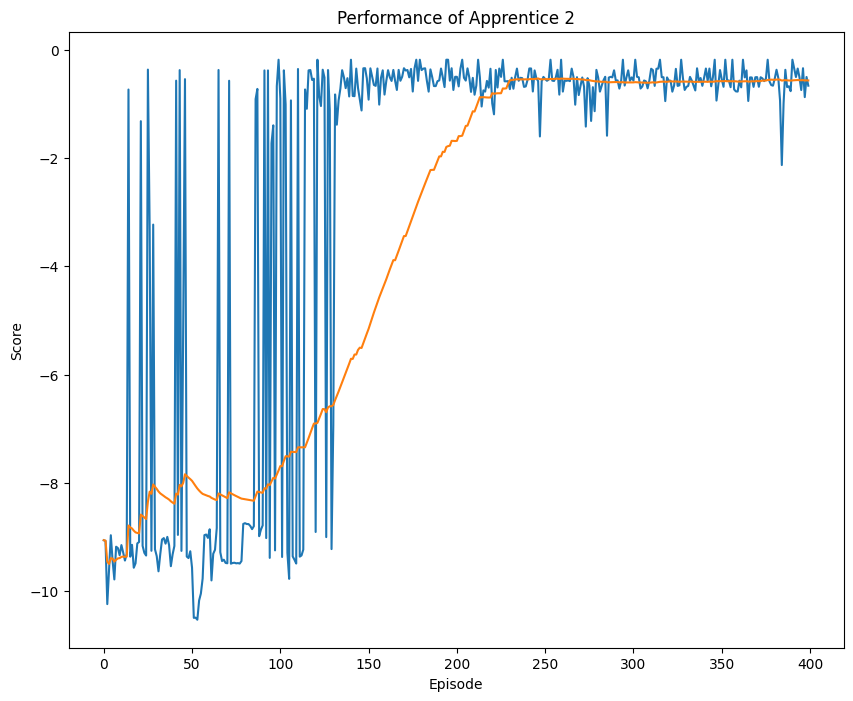

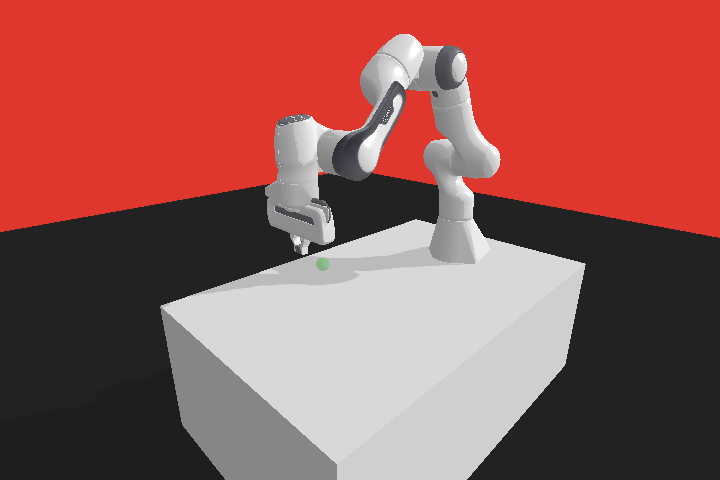

Apprentice 2 Reward:  -3.0


Calculating Average Feature Vector and Reward: 100%|█| 500/500 [00:06<00:00, 74.



Feature Expectation:  tensor([[ 0.0243,  0.0024,  0.1733, -0.2131,  0.0385, -0.2982,  0.0243,  0.0024,
          0.1733,  0.0049,  0.0020,  0.1484]], device='cuda:0')

Average Reward:  -1.852


-------------------------------------- Iteration: 3 --------------------------------------

Margin: 0.08163440227508545
Weight: tensor([[-0.0039],
        [-0.0023],
        [-0.0017],
        [-0.0561],
        [-0.0585],
        [ 0.0028],
        [-0.0039],
        [-0.0023],
        [-0.0017],
        [-0.0053],
        [-0.0013],
        [-0.0037]], device='cuda:0')
Train another apprentice agent? (y/n): y


Training..: 100%|█████████████████████████████| 400/400 [00:39<00:00, 10.05it/s]


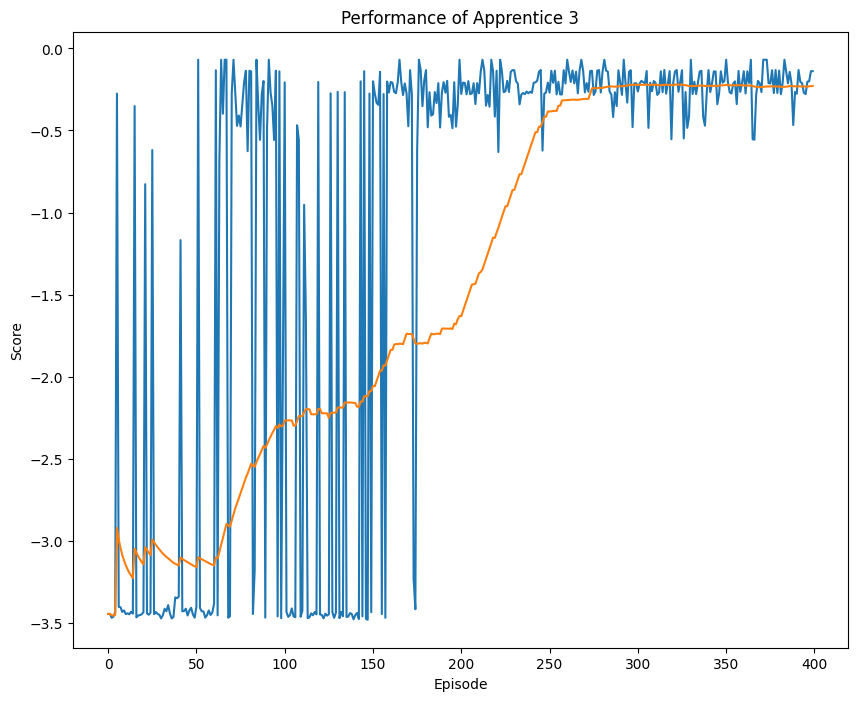

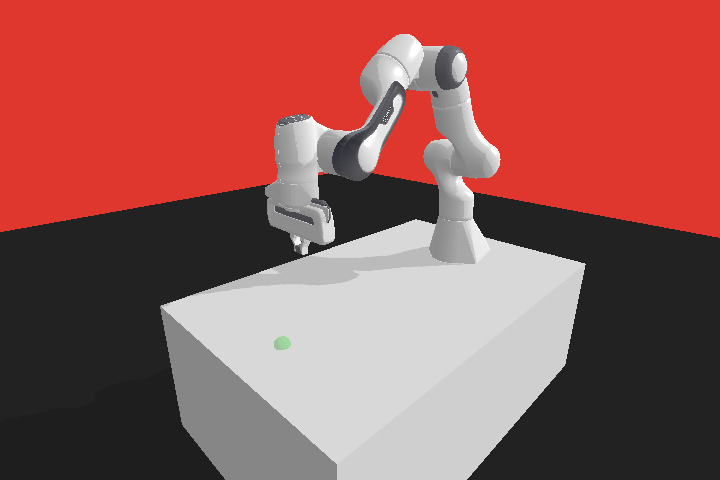

Apprentice 3 Reward:  -3.0


Calculating Average Feature Vector and Reward: 100%|█| 500/500 [00:06<00:00, 72.



Feature Expectation:  tensor([[ 0.0179, -0.0019,  0.1674, -0.2332,  0.0157, -0.3382,  0.0179, -0.0019,
          0.1674,  0.0011,  0.0035,  0.1510]], device='cuda:0')

Average Reward:  -2.586


-------------------------------------- Iteration: 4 --------------------------------------

Margin: 0.06736399233341217
Weight: tensor([[ 0.0012],
        [ 0.0015],
        [ 0.0037],
        [-0.0385],
        [-0.0387],
        [ 0.0384],
        [ 0.0012],
        [ 0.0015],
        [ 0.0037],
        [-0.0020],
        [-0.0026],
        [-0.0059]], device='cuda:0')
Train another apprentice agent? (y/n): y


Training..: 100%|█████████████████████████████| 400/400 [00:36<00:00, 10.83it/s]


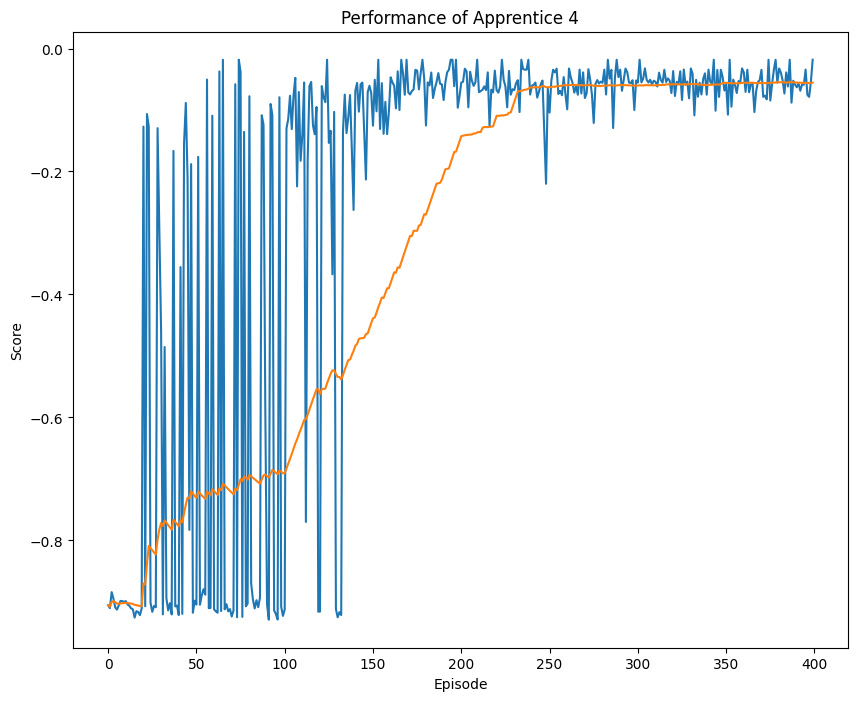

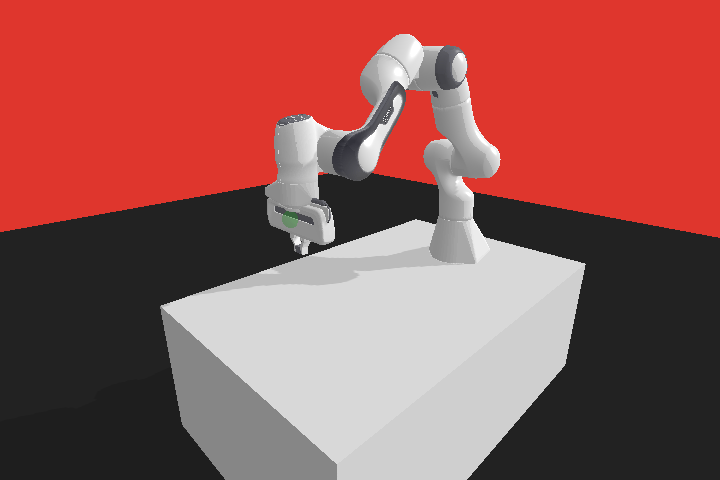

Apprentice 4 Reward:  -1.0


Calculating Average Feature Vector and Reward: 100%|█| 500/500 [00:06<00:00, 76.



Feature Expectation:  tensor([[ 0.0203,  0.0035,  0.1730, -0.2180,  0.0162, -0.2466,  0.0203,  0.0035,
          0.1730,  0.0014,  0.0036,  0.1491]], device='cuda:0')

Average Reward:  -2.028


-------------------------------------- Iteration: 5 --------------------------------------

Margin: 0.05810089036822319
Weight: tensor([[ 0.0005],
        [-0.0004],
        [ 0.0019],
        [-0.0433],
        [-0.0378],
        [ 0.0049],
        [ 0.0005],
        [-0.0004],
        [ 0.0019],
        [-0.0020],
        [-0.0027],
        [-0.0054]], device='cuda:0')
Train another apprentice agent? (y/n): y


Training..: 100%|█████████████████████████████| 400/400 [00:37<00:00, 10.68it/s]


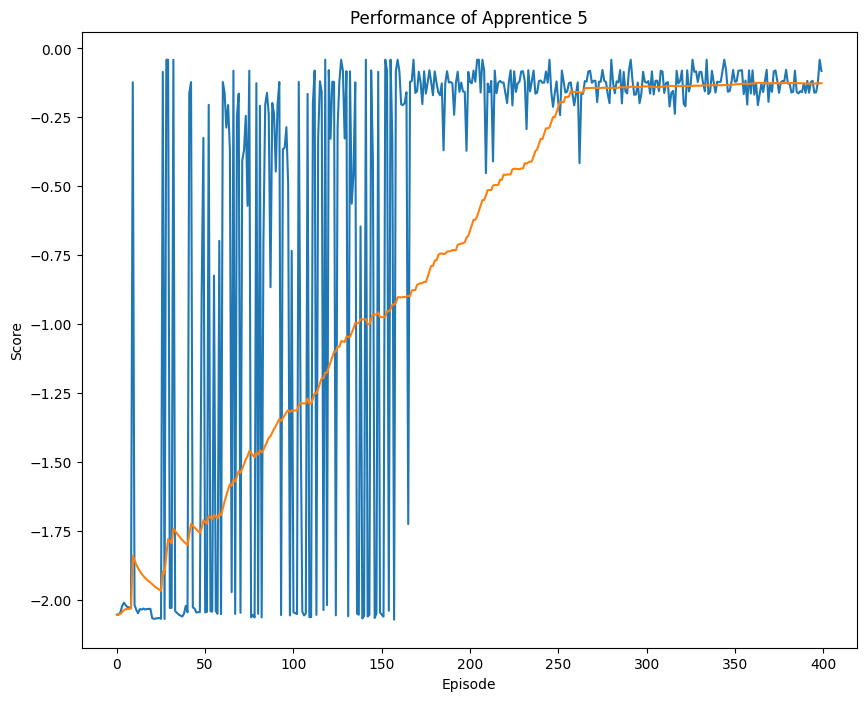

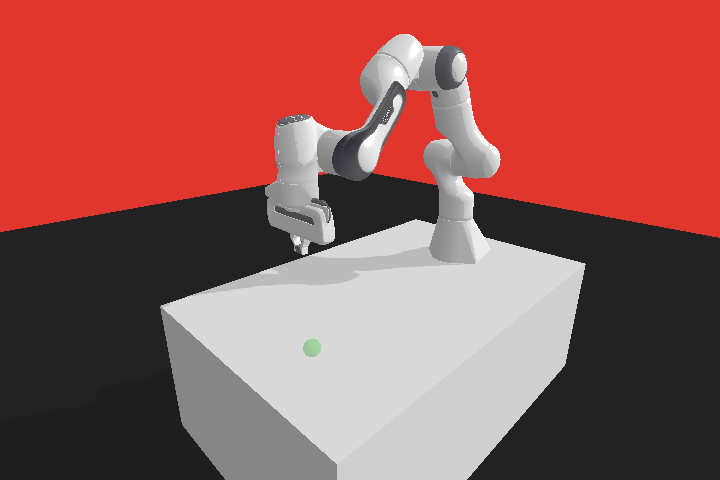

Apprentice 5 Reward:  -3.0


Calculating Average Feature Vector and Reward: 100%|█| 500/500 [00:06<00:00, 81.



Feature Expectation:  tensor([[ 2.2722e-02, -2.9797e-03,  1.7395e-01, -2.3196e-01, -2.2543e-02,
         -2.9959e-01,  2.2722e-02, -2.9797e-03,  1.7395e-01, -2.9845e-04,
         -4.8622e-03,  1.5320e-01]], device='cuda:0')

Average Reward:  -1.966


-------------------------------------- Iteration: 6 --------------------------------------

Margin: 0.039422065019607544
Weight: tensor([[-0.0029],
        [ 0.0031],
        [-0.0020],
        [-0.0371],
        [ 0.0025],
        [ 0.0051],
        [-0.0029],
        [ 0.0031],
        [-0.0020],
        [-0.0001],
        [ 0.0056],
        [-0.0085]], device='cuda:0')
Train another apprentice agent? (y/n): y


Training..: 100%|█████████████████████████████| 400/400 [01:04<00:00,  6.16it/s]


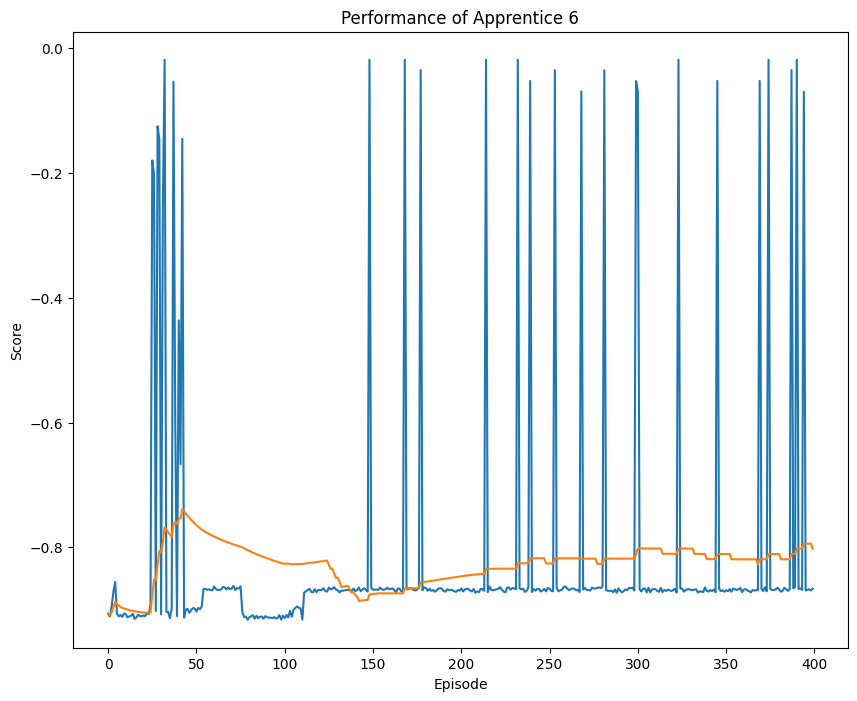

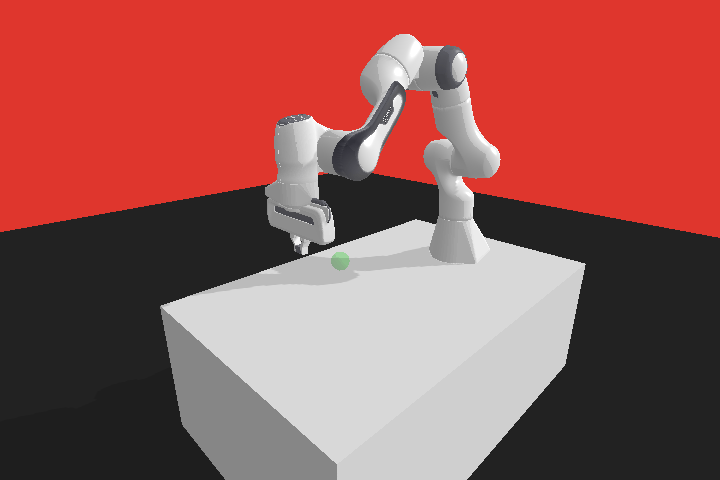

Apprentice 6 Reward:  -50.0


Calculating Average Feature Vector and Reward: 100%|█| 500/500 [00:38<00:00, 12.



Feature Expectation:  tensor([[-0.6639, -0.5152,  0.0280, -0.4182, -0.2300, -0.1072, -0.6639, -0.5152,
          0.0280, -0.0011, -0.0054,  0.1508]], device='cuda:0')

Average Reward:  -46.466


-------------------------------------- Iteration: 7 --------------------------------------

Margin: 0.03881891071796417
Weight: tensor([[ 0.0008],
        [ 0.0059],
        [-0.0012],
        [-0.0361],
        [ 0.0036],
        [ 0.0041],
        [ 0.0008],
        [ 0.0059],
        [-0.0012],
        [-0.0001],
        [ 0.0056],
        [-0.0085]], device='cuda:0')
Train another apprentice agent? (y/n): y


Training..: 100%|█████████████████████████████| 400/400 [00:38<00:00, 10.35it/s]


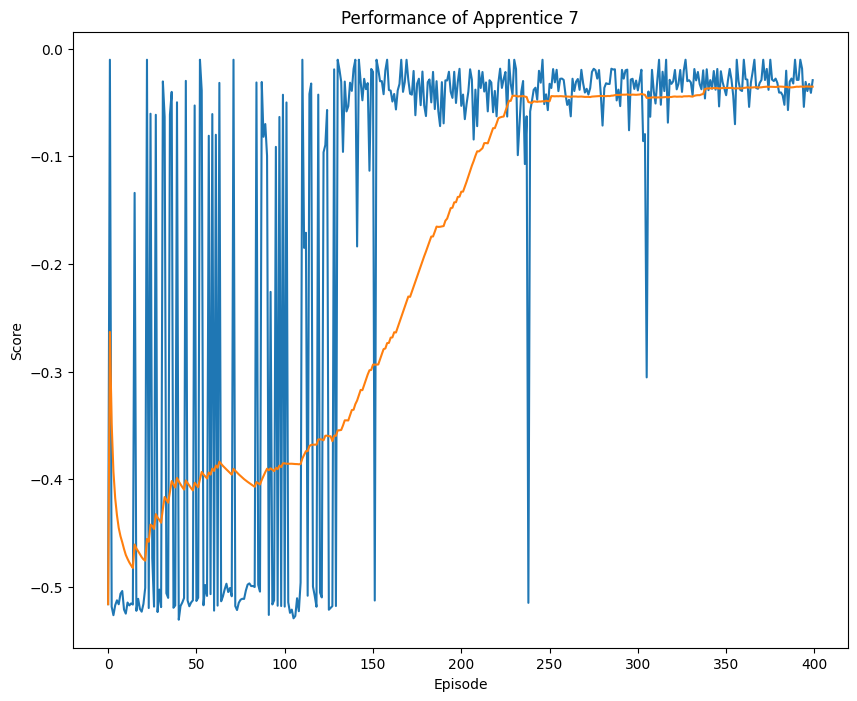

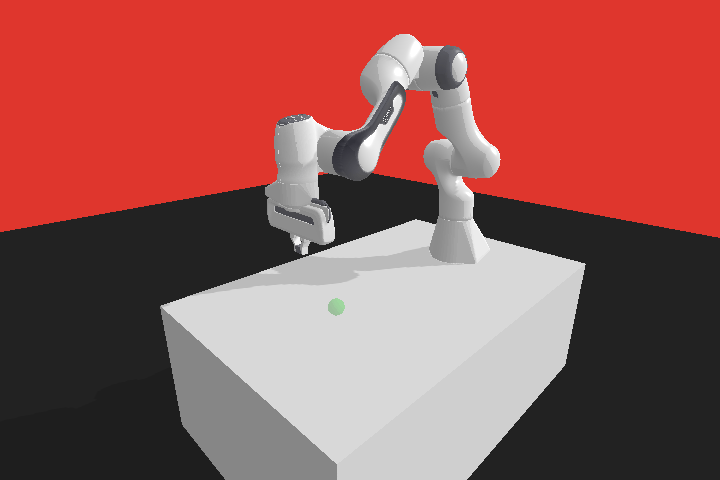

Apprentice 7 Reward:  -1.0


Calculating Average Feature Vector and Reward: 100%|█| 500/500 [00:07<00:00, 68.



Feature Expectation:  tensor([[ 0.0219, -0.0093,  0.1782, -0.2051, -0.1008, -0.2303,  0.0219, -0.0093,
          0.1782,  0.0011, -0.0073,  0.1540]], device='cuda:0')

Average Reward:  -2.196


-------------------------------------- Iteration: 8 --------------------------------------

Margin: 0.037491898983716965
Weight: tensor([[ 1.0486e-03],
        [ 5.5735e-03],
        [-7.4075e-04],
        [-3.3436e-02],
        [-3.6249e-03],
        [ 1.0464e-02],
        [ 1.0486e-03],
        [ 5.5735e-03],
        [-7.4075e-04],
        [-3.4479e-06],
        [ 5.3395e-03],
        [-8.4340e-03]], device='cuda:0')
Train another apprentice agent? (y/n): y


Training..: 100%|█████████████████████████████| 400/400 [00:38<00:00, 10.46it/s]


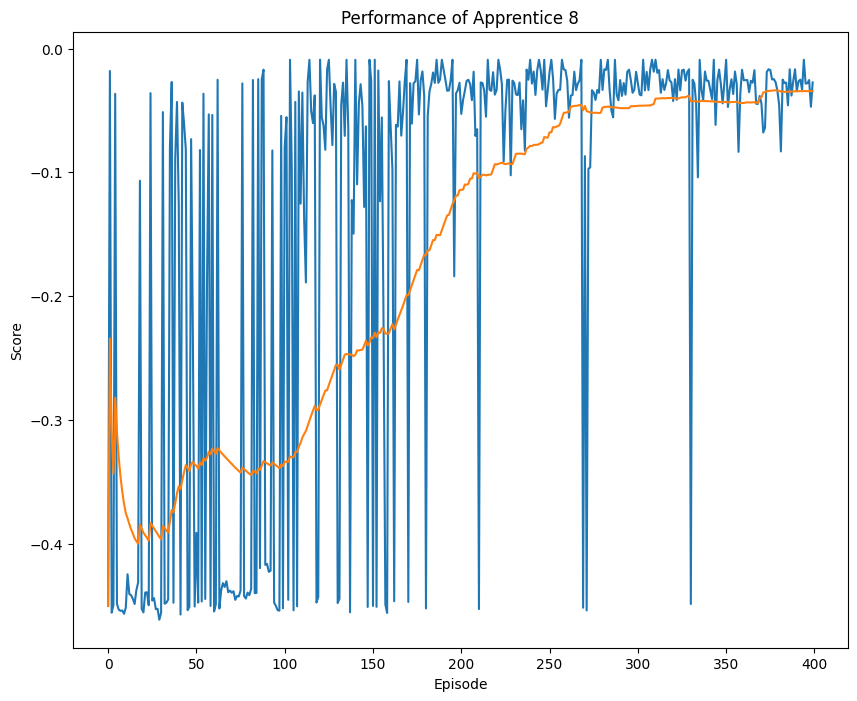

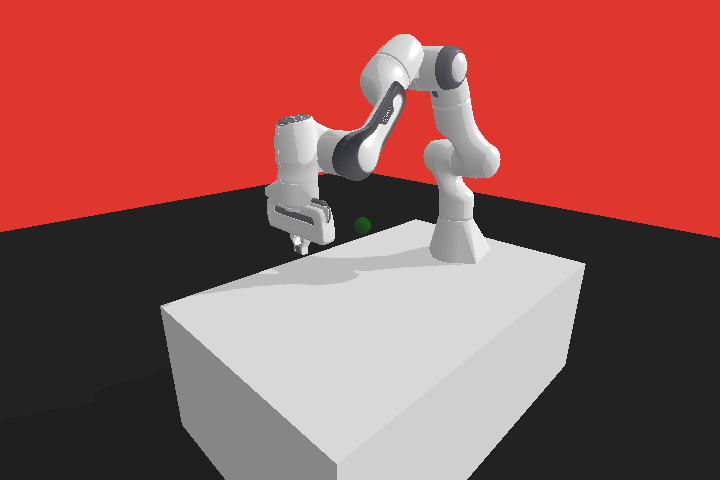

Apprentice 8 Reward:  -1.0


Calculating Average Feature Vector and Reward: 100%|█| 500/500 [00:06<00:00, 72.



Feature Expectation:  tensor([[ 0.0183, -0.0009,  0.1625, -0.2388,  0.0038, -0.2894,  0.0183, -0.0009,
          0.1625,  0.0040, -0.0027,  0.1442]], device='cuda:0')

Average Reward:  -2.444


-------------------------------------- Iteration: 9 --------------------------------------

Margin: 0.035878296941518784
Weight: tensor([[ 0.0012],
        [ 0.0040],
        [ 0.0028],
        [-0.0323],
        [-0.0105],
        [ 0.0051],
        [ 0.0012],
        [ 0.0040],
        [ 0.0028],
        [-0.0015],
        [ 0.0047],
        [-0.0054]], device='cuda:0')
Train another apprentice agent? (y/n): y


Training..: 100%|█████████████████████████████| 400/400 [00:40<00:00,  9.86it/s]


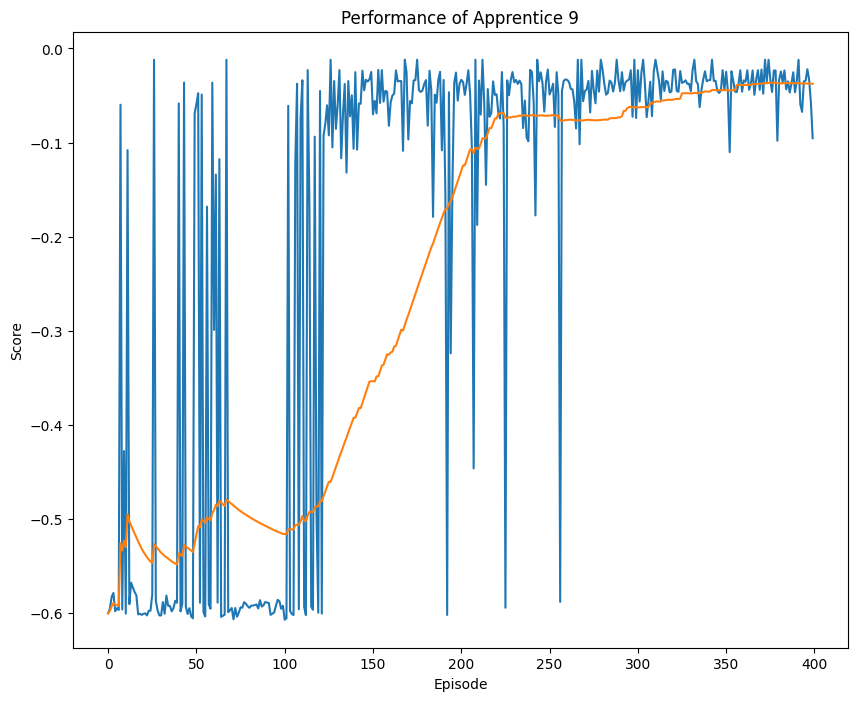

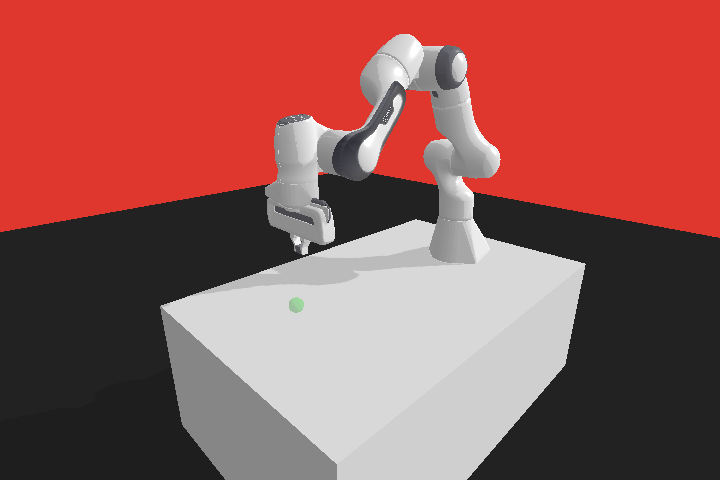

Apprentice 9 Reward:  -3.0


Calculating Average Feature Vector and Reward: 100%|█| 500/500 [00:06<00:00, 73.



Feature Expectation:  tensor([[ 0.0178,  0.0009,  0.1682, -0.2130,  0.0032, -0.2582,  0.0178,  0.0009,
          0.1682,  0.0047, -0.0010,  0.1464]], device='cuda:0')

Average Reward:  -2.376


-------------------------------------- Iteration: 10 --------------------------------------

Margin: 0.03363701328635216
Weight: tensor([[ 0.0010],
        [ 0.0052],
        [ 0.0025],
        [-0.0265],
        [-0.0074],
        [ 0.0154],
        [ 0.0010],
        [ 0.0052],
        [ 0.0025],
        [-0.0006],
        [ 0.0054],
        [-0.0063]], device='cuda:0')
Train another apprentice agent? (y/n): y


Training..: 100%|█████████████████████████████| 400/400 [00:43<00:00,  9.28it/s]


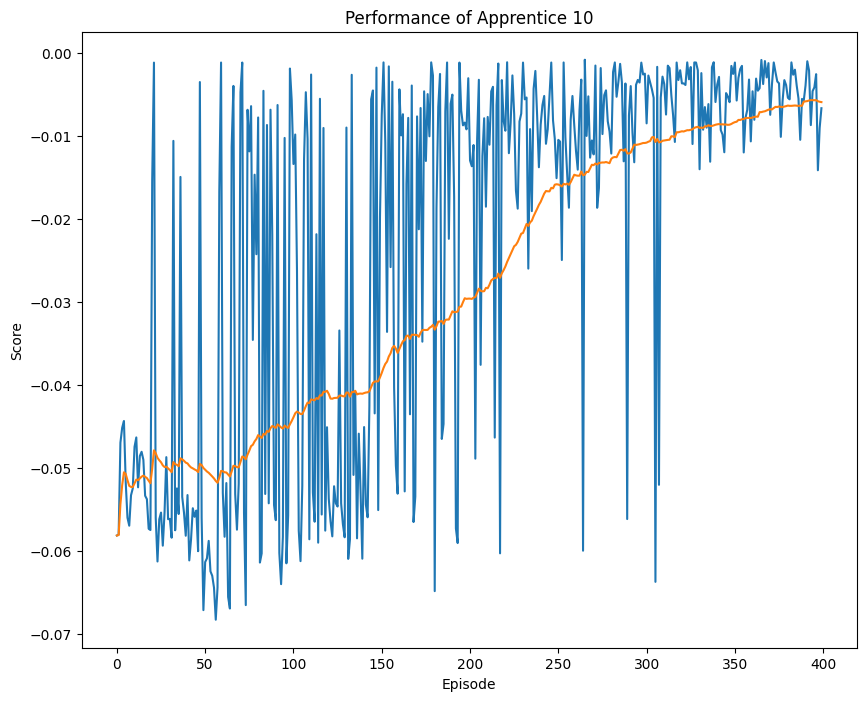

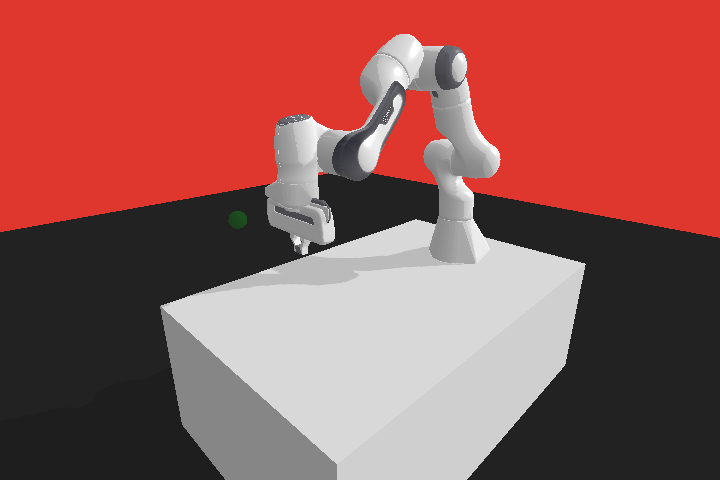

Apprentice 10 Reward:  -3.0


Calculating Average Feature Vector and Reward: 100%|█| 500/500 [00:07<00:00, 68.



Feature Expectation:  tensor([[ 0.0106, -0.0062,  0.1754, -0.1551,  0.0099, -0.1142,  0.0106, -0.0062,
          0.1754,  0.0014, -0.0021,  0.1533]], device='cuda:0')

Average Reward:  -3.258


-------------------------------------- Iteration: 11 --------------------------------------

Margin: 0.03354356810450554
Weight: tensor([[ 0.0011],
        [ 0.0053],
        [ 0.0024],
        [-0.0275],
        [-0.0076],
        [ 0.0132],
        [ 0.0011],
        [ 0.0053],
        [ 0.0024],
        [-0.0006],
        [ 0.0054],
        [-0.0063]], device='cuda:0')
Train another apprentice agent? (y/n): n


In [10]:
rewards, margins = projection_method_algorithm(env, n_episodes=400, m=500, exploration_period=100)

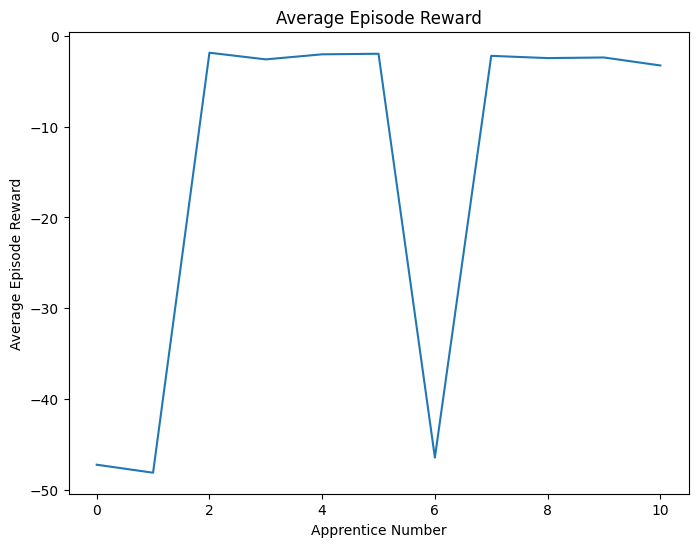

In [11]:
# Performance comparison of apprentices

plt.figure(figsize=(8, 6))
plt.plot(rewards)
plt.title('Average Episode Reward')
plt.xlabel('Apprentice Number')
plt.ylabel('Average Episode Reward')
plt.savefig("../Results/DDPG/Apprentice Rewards.png")
plt.show()

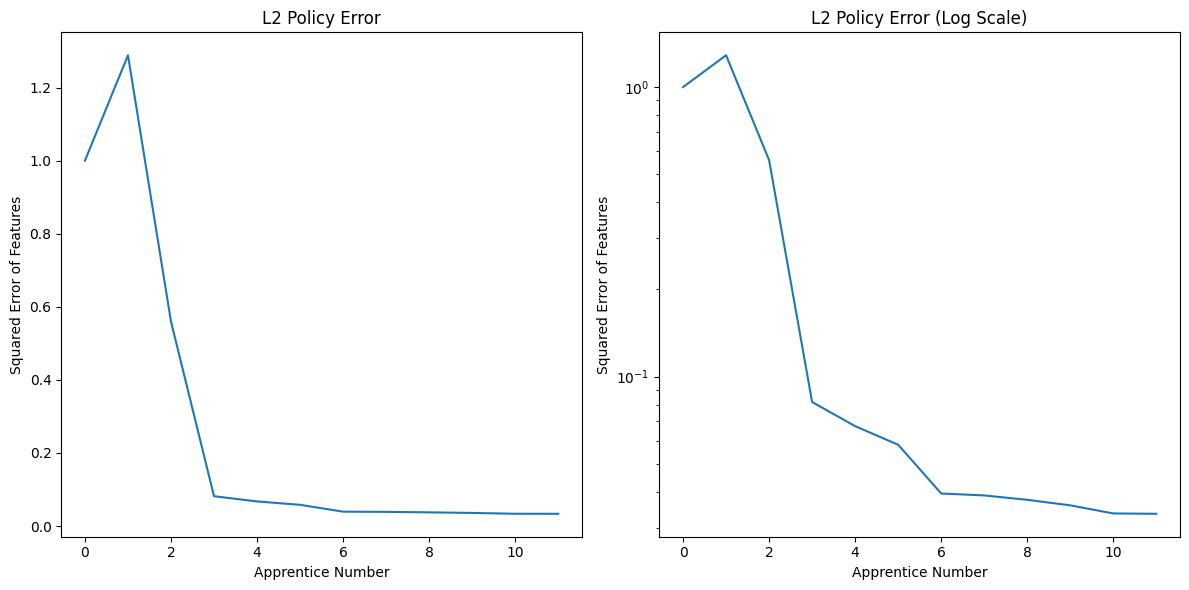

In [12]:
# L2 Policy Error
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# plot without log scale
axes[0].plot(margins, label="L2 Policy Error")
axes[0].set_title("L2 Policy Error")
axes[0].set_xlabel("Apprentice Number")
axes[0].set_ylabel("Squared Error of Features")

# plot with log scale
axes[1].plot(margins, label="L2 Policy Error")
axes[1].set_title("L2 Policy Error (Log Scale)")
axes[1].set_xlabel("Apprentice Number")
axes[1].set_ylabel("Squared Error of Features")
axes[1].set_yscale("log")

plt.tight_layout()
plt.savefig("../Results/DDPG/Apprentice Policy Error.png")
plt.show()